In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
import en_core_web_sm
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df=pd.read_csv("/content/drive/MyDrive/train (1).csv",encoding='ISO-8859-1')

In [7]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df.shape

(7613, 5)

In [9]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Preprocessing the text

In [11]:
# removing https tags

In [12]:
df['processed_tweet']=df['text'].apply(lambda x:re.sub(r'https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

In [13]:
df['processed_tweet'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [14]:
#removing hashtags

In [15]:
df['hastag']=df['processed_tweet'].apply(lambda x:re.findall(r'#\S+', x))

In [16]:
df['processed_tweet'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: processed_tweet, dtype: object

In [17]:
df['hastag']=df['hastag'].apply(lambda x:x[1:])

In [18]:
#removing usernames

In [19]:
df['processed_tweet']=df['processed_tweet'].apply(lambda x:re.sub(r'@\S+', '', x))

In [20]:
#removing punctuations

In [21]:
def remove_punctuations(df):
    data=df['processed_tweet']
    
    symbols = "!\"#$%&()*+-.',/:;<=>?@[\]^_`{|}~\n"
    for i in symbols:
        data = np.char.replace(data, i, '')
    return data

In [22]:
df['processed_tweet']=df.apply(remove_punctuations,axis=1)

In [23]:
df['processed_tweet'][0]

array('Our Deeds are the Reason of this earthquake May ALLAH Forgive us all',
      dtype='<U68')

In [24]:
#converting to lower case

In [25]:
df['processed_tweet']=df['processed_tweet'].apply(lambda x:str(x).lower())

In [206]:
df['processed_tweet'][0:5]

0                 reason earthquak may forgiv
1                     forest fire near canada
2    shelter place notifi evacu shelter place
3                          peopl receiv evacu
4            got send photo rubi smoke school
Name: processed_tweet, dtype: object

In [27]:
#removing the numbers

In [28]:
df['processed_tweet']=df['processed_tweet'].apply(lambda x:' '.join([ re.sub(r'[0-9]+', '', item)  for item in x.split() ]))

In [29]:
df['processed_tweet']=df['processed_tweet'].apply(lambda x:' '.join([ item.replace(r'¼', 'l')  for item in x.split() ]))

df['processed_tweet']=df['processed_tweet'].apply(lambda x:' '.join([ re.sub(r'ã¼+', 'al', item)  for item in x.split() ]))



In [30]:
df['processed_tweet']=df['processed_tweet'].apply(lambda x:' '.join([ item.replace(r'ã', 'a')  for item in x.split() ]))

In [31]:
df['processed_tweet']=df['processed_tweet'].apply(lambda x:' '.join([ item.replace(r'â', 'a')  for item in x.split() ]))

In [32]:
#removing the stop words

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
stop = stopwords.words('english')
df['processed_tweet']=df['processed_tweet'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [35]:
df['processed_tweet'][0:19]

0          deeds reason earthquake may allah forgive us
1                 forest fire near la ronge sask canada
2     residents asked shelter place notified officer...
3     people receive wildfires evacuation orders cal...
4     got sent photo ruby alaska smoke wildfires pou...
5     rockyfire update california hwy closed directi...
6     flood disaster heavy rain causes flash floodin...
7                            im top hill see fire woods
8     theres emergency evacuation happening building...
9                         im afraid tornado coming area
10                      three people died heat wave far
11    haha south tampa getting flooded hah wait seco...
12    raining flooding florida tampabay tampa days i...
13                      flood bago myanmar arrived bago
14           damage school bus multi car crash breaking
15                                            whats man
16                                          love fruits
17                                        summer

In [37]:
df['processed_tweet']=df['processed_tweet'].apply(lambda x:str(x).strip())

# removing non english words

In [36]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [38]:
def non_eng_words(df):
    sent=df['processed_tweet']
    words = set(nltk.corpus.words.words())
    sent = " ".join(w for w in nltk.wordpunct_tokenize(sent) if w.lower() in words or not w.isalpha())
    return sent

In [39]:
df['processed_tweet']=df.apply(non_eng_words,axis=1)

In [40]:
df['processed_tweet'].head(19)

0                      reason earthquake may forgive us
1                            forest fire near la canada
2       shelter place notified evacuation shelter place
3                             people receive evacuation
4                      got sent photo ruby smoke school
5                    update closed due lake county fire
6     flood disaster heavy rain flash flooding stree...
7                                     top hill see fire
8     theres emergency evacuation happening building...
9                            afraid tornado coming area
10                           three people heat wave far
11    south getting flooded hah wait second live sou...
12                             flooding days lost count
13                                      flood bago bago
14                 damage school bus car crash breaking
15                                            whats man
16                                                 love
17                                        summer

In [42]:
#Lammentation

In [41]:
stemmer = PorterStemmer()
spacy_nlp_en = spacy.load('en_core_web_sm')

In [43]:
df['processed_tweet']=df['processed_tweet'].apply(lambda x:' '.join([word.lemma_ for word in spacy_nlp_en(x)]))

In [44]:
df['processed_tweet']=df['processed_tweet'].apply(lambda x: x.split())

In [45]:
df['processed_tweet']=df['processed_tweet'].apply(lambda x: [stemmer.stem(i) for i in x])

In [46]:
#stemming

In [47]:
# removing the words that has word length less than =2

In [48]:
df['processed_tweet']=df['processed_tweet'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))



In [49]:
df['processed_tweet'].head()


0                 reason earthquak may forgiv
1                     forest fire near canada
2    shelter place notifi evacu shelter place
3                          peopl receiv evacu
4            got send photo rubi smoke school
Name: processed_tweet, dtype: object

import nltk
nltk.download('words')


In [53]:
df['hastag']=df['hastag'].apply(lambda x : str(x))


In [ ]:
df['processed_tweet'][29]

'like'

### EDA

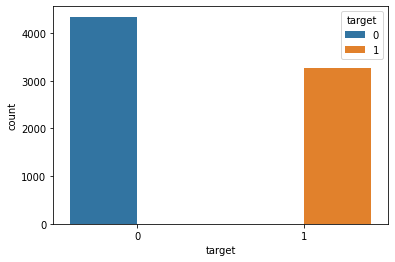

In [50]:
sns.countplot(data=df,x='target',hue='target')

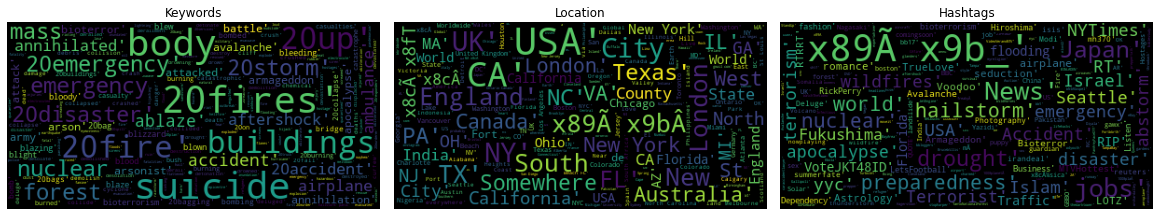

In [54]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

keyword_words = str(df['keyword']
    .dropna()
    .unique()
    .tolist()
)

location_words = str(df['location']
    .dropna()
    .unique()
    .tolist()
)

hashtag_words = str(df['hastag']
    .dropna()
    .unique()
    .tolist()
)

keyword_wordcloud = WordCloud(
    background_color='black',
    stopwords=None,
    max_words=200,
    max_font_size=40, 
    random_state=42
).generate(keyword_words)

location_wordcloud = WordCloud(
    background_color='black',
    stopwords=None,
    max_words=200,
    max_font_size=40, 
    random_state=42
).generate(location_words)

hashtag_wordcloud = WordCloud(
    background_color='black',
    stopwords=None,
    max_words=200,
    max_font_size=40, 
    random_state=42
).generate(hashtag_words)

fig, ax = plt.subplots(1,3, figsize=(16,9), constrained_layout=True)
ax[0].set_title("Keywords")
ax[0].imshow(keyword_wordcloud)
ax[0].axis(False)
ax[1].set_title('Location')
ax[1].imshow(location_wordcloud)
ax[1].axis(False)
ax[2].set_title('Hashtags')
ax[2].imshow(hashtag_wordcloud)
ax[2].axis(False)
plt.show()


In [55]:
df['text length'] = df['processed_tweet'].str.len()
df['text length'] = df['processed_tweet'].str.len()
df.head()

,id,keyword,location,text,target,processed_tweet,hastag,text length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,reason earthquak may forgiv,[],27
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near canada,[],23
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,shelter place notifi evacu shelter place,[],40
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv evacu,[],18
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got send photo rubi smoke school,['#wildfires'],32


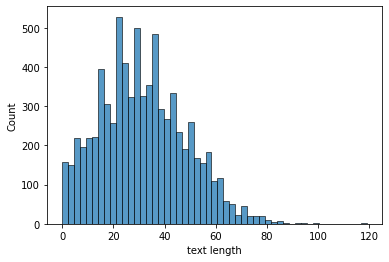

In [56]:
sns.histplot(data=df,x="text length")

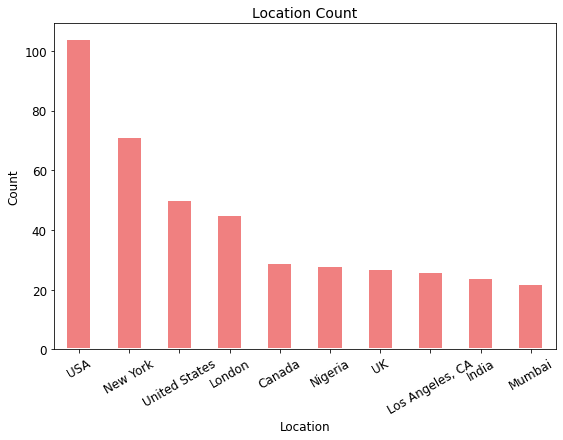

In [57]:
plt.figure(figsize = (9, 6))
ax = plt.axes()
ax.set_facecolor('white')
ax = ((df.location.value_counts())[:10]).plot(kind = 'bar', color = 'lightcoral', linewidth = 2, edgecolor = 'white')
plt.title('Location Count', fontsize = 14)
plt.xlabel('Location', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
ax.xaxis.set_tick_params(labelsize = 12, rotation = 30)
ax.yaxis.set_tick_params(labelsize = 12)

In [58]:
number_of_unique_keywords=df['keyword'].unique().size
print(f'Number of unique keywords: {number_of_unique_keywords}')

Number of unique keywords: 222


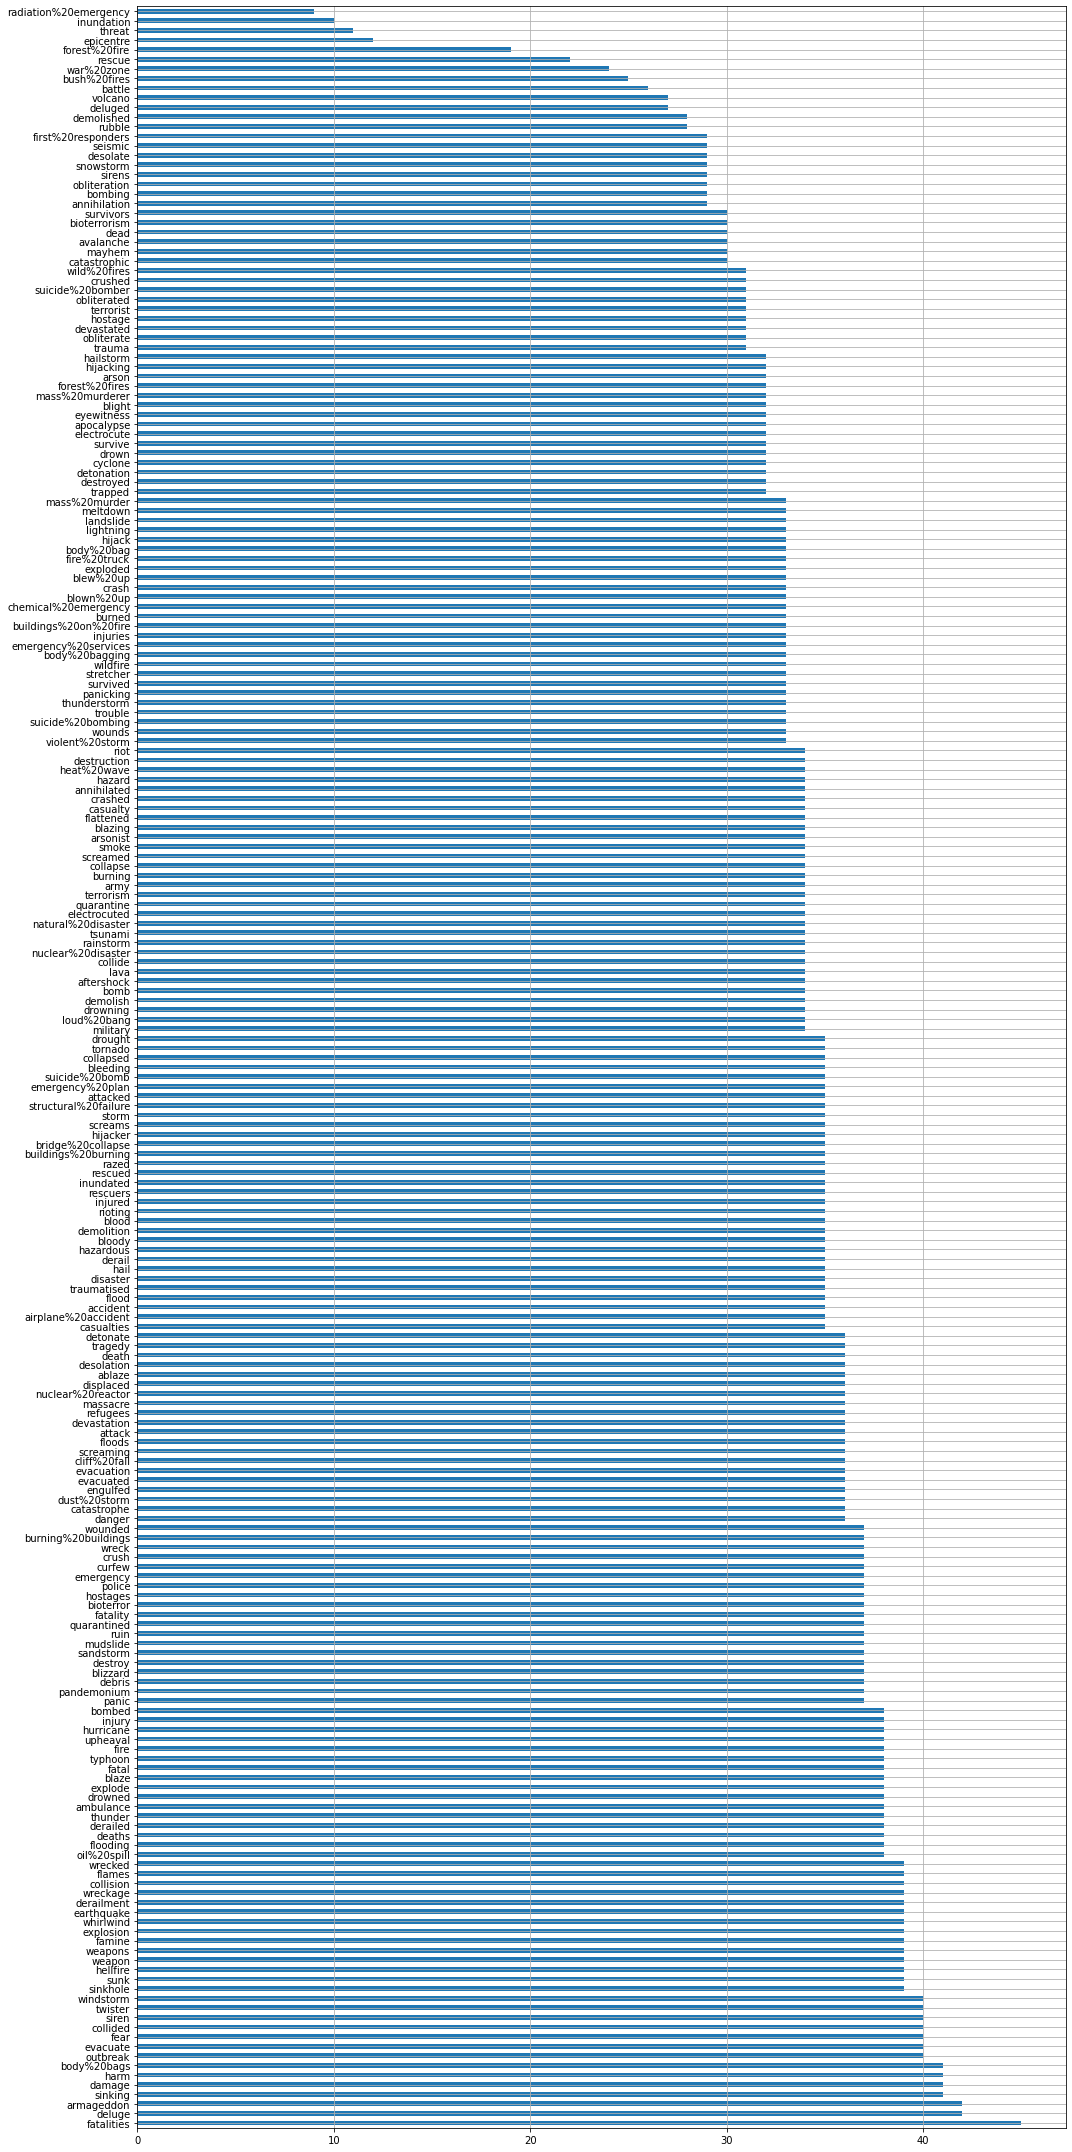

In [59]:
plt.rcParams["figure.figsize"] = [15, 30]
plt.rcParams["figure.autolayout"] = True
df['keyword'].value_counts().plot(kind='barh')
plt.grid(True)

In [60]:
from collections import defaultdict

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.split(' ') if token != '']
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 50
DISASTER_TWEETS = df['target'] == 1
# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df[DISASTER_TWEETS]['processed_tweet']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df[~DISASTER_TWEETS]['processed_tweet']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1

df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])


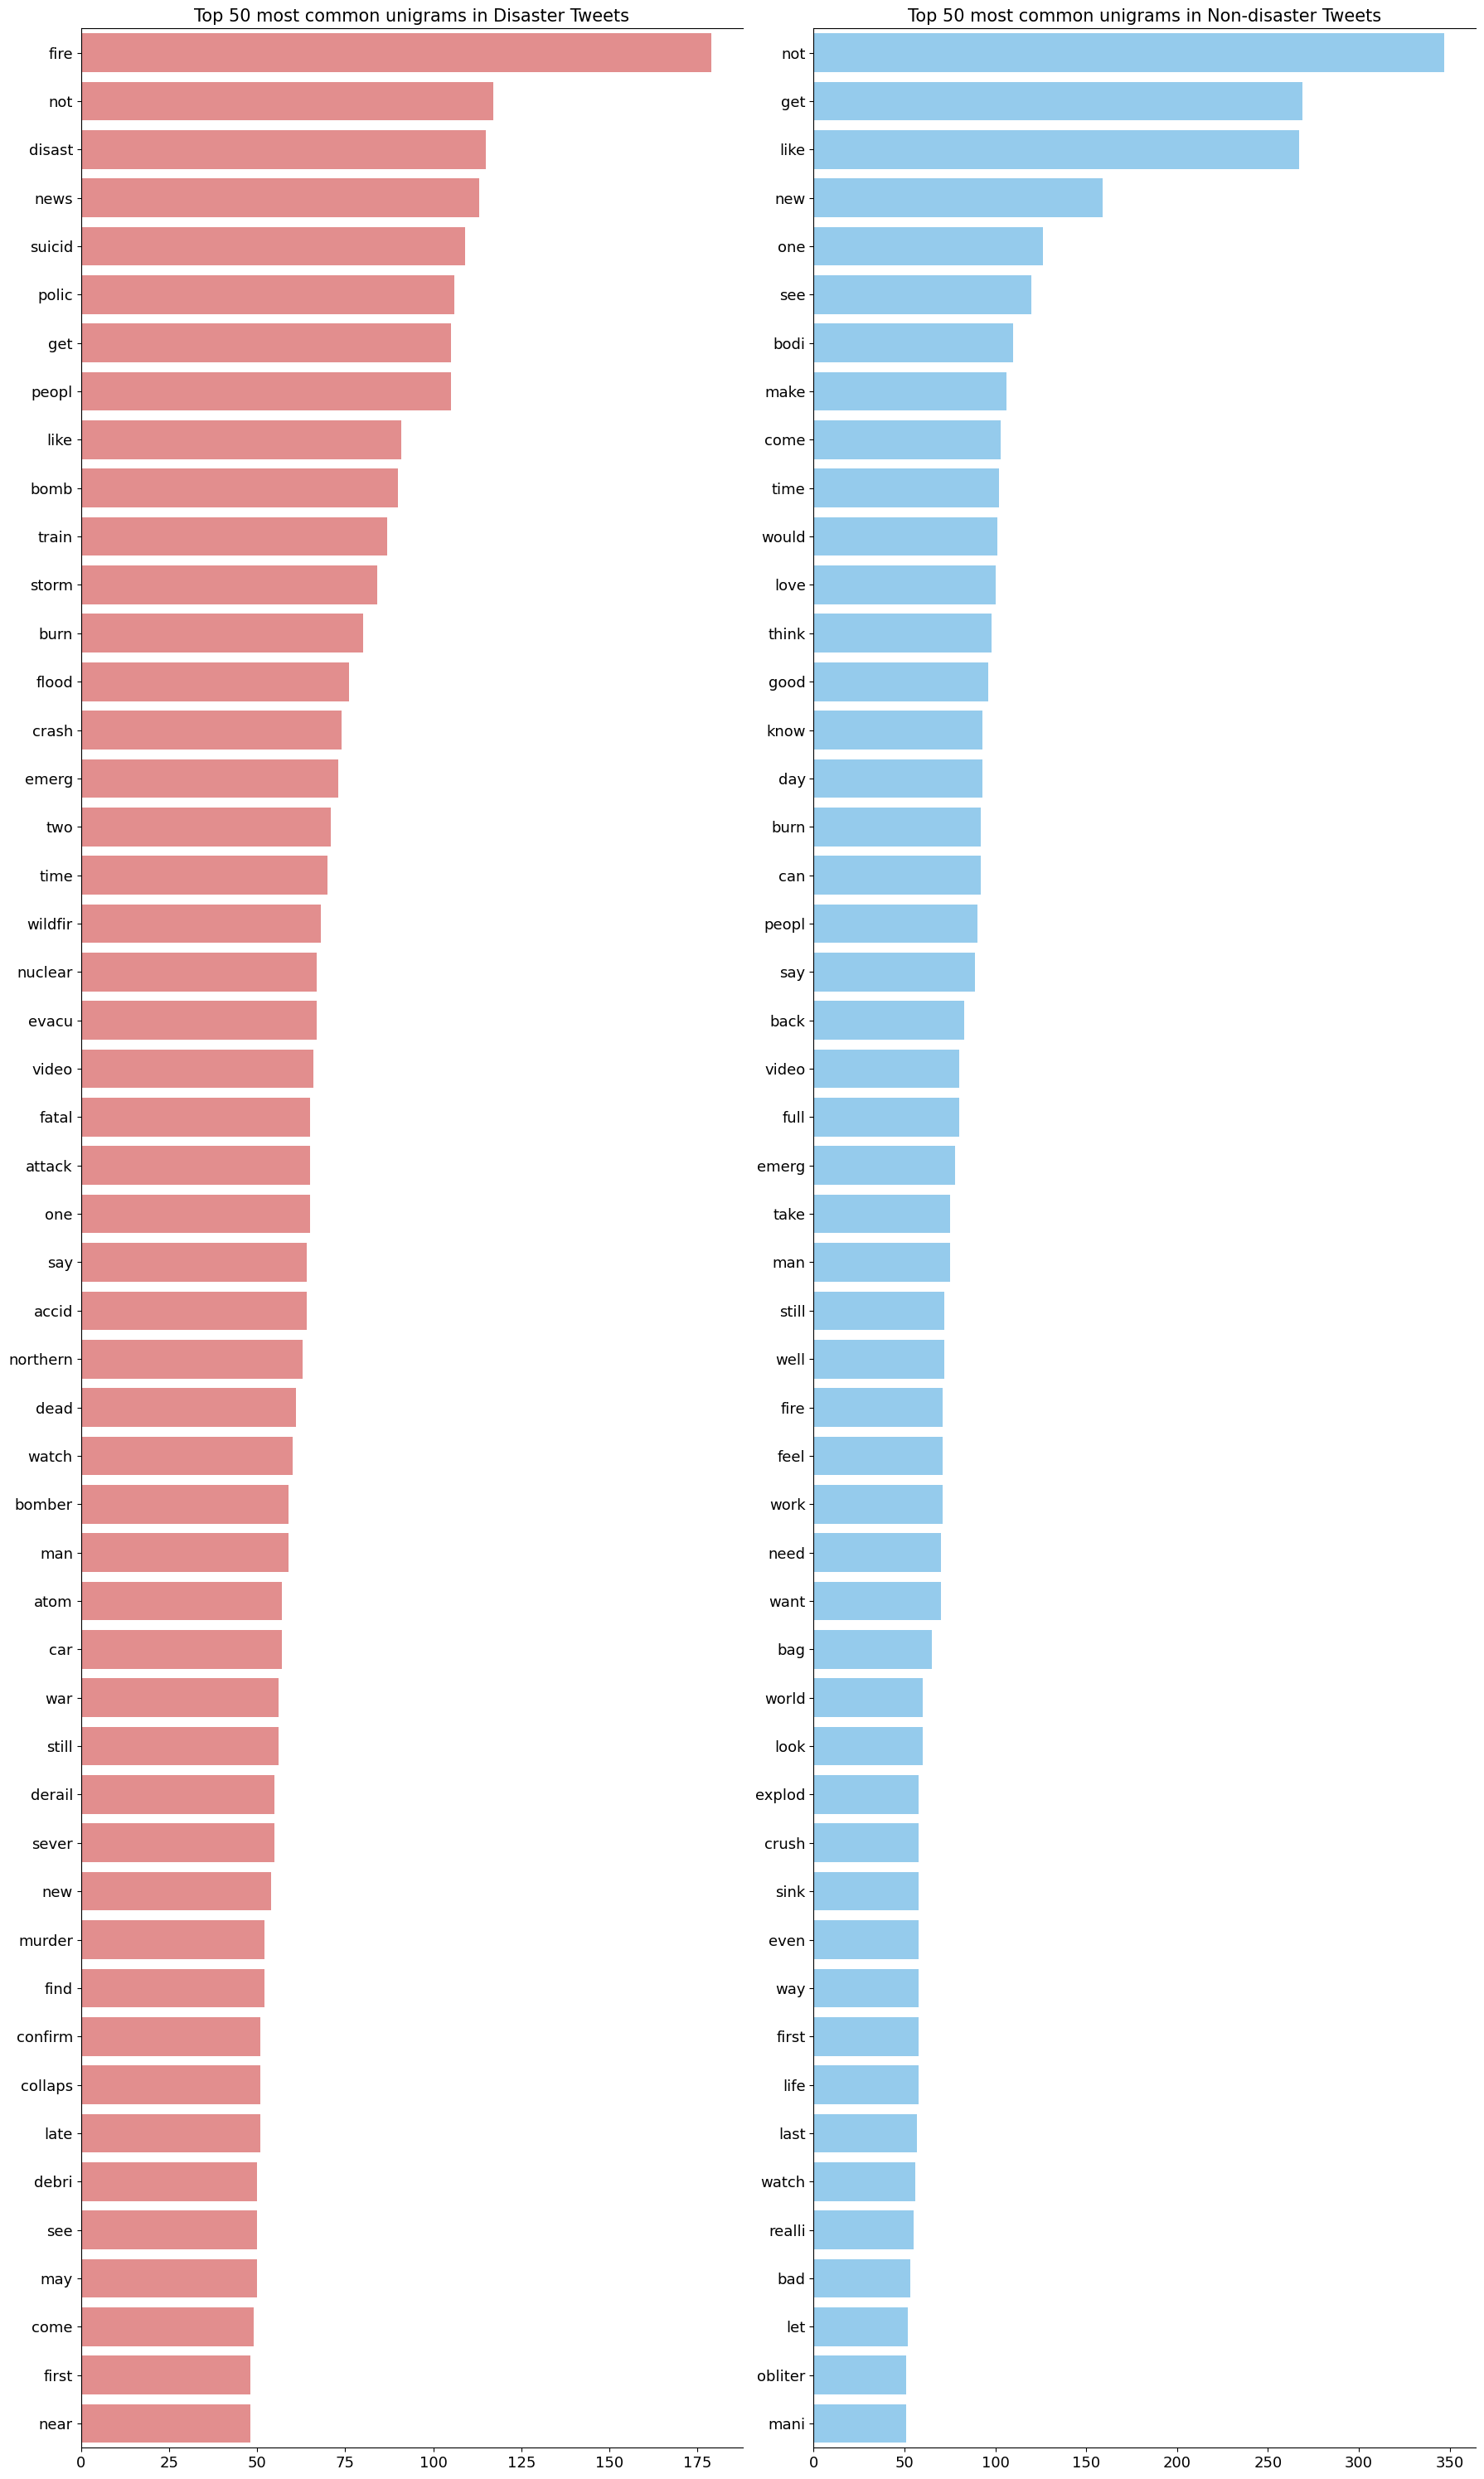

In [61]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='lightcoral')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='lightskyblue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

In [62]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [63]:
X = df['processed_tweet']
y = df['target']

In [64]:
print(X.shape)
print(y.shape)

(7613,)
(7613,)


In [65]:
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, random_state=1,test_size=0.25)

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [67]:
vect.fit(X_train)

CountVectorizer()

In [68]:
# printing the vocabulary
vect.vocabulary_

{'snipe': 3581,
 'bloodi': 421,
 'insomnia': 1992,
 'fire': 1481,
 'hazard': 1788,
 'associ': 231,
 'instal': 1995,
 'extern': 1384,
 'clad': 718,
 'truckload': 4089,
 'blow': 424,
 'nobodi': 2579,
 'one': 2645,
 'littl': 2236,
 'lion': 2223,
 'everyon': 1341,
 'mind': 2416,
 'crush': 939,
 'ignit': 1912,
 'knock': 2113,
 'deton': 1074,
 'sensor': 3413,
 'connector': 832,
 'weather': 4330,
 'outlook': 2687,
 'mortal': 2480,
 'clay': 724,
 'pigeon': 2823,
 'shoot': 3470,
 'cri': 924,
 'aftershock': 65,
 'fear': 1438,
 'rainstorm': 3076,
 'big': 380,
 'troubl': 4085,
 'race': 3059,
 'find': 1475,
 'solut': 3610,
 'need': 2545,
 'team': 3895,
 'hair': 1748,
 'poverti': 2913,
 'moment': 2456,
 'get': 1637,
 'fade': 1398,
 'weekend': 4335,
 'wick': 4372,
 'surround': 3839,
 'mayb': 2349,
 'that': 3930,
 'tornado': 4012,
 'volcano': 4282,
 'breath': 484,
 'like': 2215,
 'windstorm': 4385,
 'cool': 863,
 'respons': 3210,
 'interview': 2018,
 'part': 2742,
 'sing': 3513,
 'tsunami': 4098,
 'co

In [69]:
# vocab size
len(vect.vocabulary_.keys())

4468

In [70]:
# transforming the train and test datasets
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

In [71]:
# note that the type is transformed (sparse) matrix
print(type(X_train_transformed))
print(X_train_transformed)

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 3581)	1
  (1, 421)	1
  (1, 1992)	2
  (2, 231)	1
  (2, 718)	1
  (2, 1384)	1
  (2, 1481)	1
  (2, 1788)	1
  (2, 1995)	1
  (3, 424)	1
  (3, 1341)	1
  (3, 2223)	1
  (3, 2236)	1
  (3, 2416)	1
  (3, 2579)	1
  (3, 2645)	1
  (3, 4089)	1
  (4, 939)	1
  (5, 832)	1
  (5, 1074)	1
  (5, 1912)	1
  (5, 2113)	1
  (5, 3413)	1
  (6, 1788)	1
  (6, 2687)	1
  :	:
  (5704, 2215)	1
  (5704, 2499)	1
  (5704, 2597)	1
  (5704, 3396)	1
  (5704, 3511)	1
  (5704, 3929)	1
  (5704, 4098)	1
  (5704, 4321)	1
  (5705, 1088)	1
  (5705, 1653)	1
  (5705, 3349)	1
  (5705, 3713)	1
  (5705, 3967)	1
  (5705, 4301)	1
  (5706, 908)	2
  (5706, 2328)	2
  (5706, 3301)	1
  (5706, 3730)	2
  (5706, 3805)	1
  (5707, 11)	1
  (5707, 1739)	1
  (5708, 128)	1
  (5708, 777)	1
  (5708, 1268)	1
  (5708, 4036)	1


In [72]:
# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# fit
mnb.fit(X_train_transformed,y_train)

# predict class
y_pred_class = mnb.predict(X_test_transformed)

# predict probabilities
y_pred_proba = mnb.predict_proba(X_test_transformed)

In [73]:
# note that alpha=1 is used by default for smoothing
mnb

MultinomialNB()

In [74]:
# printing the overall accuracy
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.7662815126050421

In [75]:
y_test.value_counts()

0    1086
1     818
Name: target, dtype: int64

In [76]:
# confusion matrix
cm=metrics.confusion_matrix(y_test, y_pred_class)
cm

array([[914, 172],
       [273, 545]])

In [77]:
"{:2.2f}".format(metrics.roc_auc_score(y_test, y_pred_class))

'0.75'

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [79]:
tfidfconverter = TfidfVectorizer()
x_train_tfidf = tfidfconverter.fit_transform(list(X_train)).toarray()
x_train_tfidf_all = pd.DataFrame(x_train_tfidf,columns=tfidfconverter.get_feature_names())



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [80]:
x_test_tfidf = tfidfconverter.transform(list(X_test)).toarray()
x_test_tfidf_all = pd.DataFrame(x_test_tfidf,columns=tfidfconverter.get_feature_names())



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [81]:
l1=x_train_tfidf_all.columns


In [82]:
#for i in l1:
   # print(i)

In [83]:
len(l1)

4468

Logistic Regression

In [86]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
model1=lr.fit(x_train_tfidf_all, y_train)

In [89]:
y_train_pred = lr.predict(x_train_tfidf_all)
y_test_pred = lr.predict(x_test_tfidf_all)

In [90]:
print(accuracy_score(y_test, y_test_pred))

0.7767857142857143


In [91]:
"{:2.2f}".format(metrics.roc_auc_score(y_test, y_test_pred))

'0.76'

In [100]:
# confusion matrix
cm=metrics.confusion_matrix(y_test, y_test_pred)
cm

array([[961, 125],
       [300, 518]])

In [98]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1086
           1       0.81      0.63      0.71       818

    accuracy                           0.78      1904
   macro avg       0.78      0.76      0.76      1904
weighted avg       0.78      0.78      0.77      1904



### Decision Tree

In [92]:
from sklearn.tree import DecisionTreeClassifier

In [101]:
dt = DecisionTreeClassifier()
dt.fit(x_train_tfidf_all, y_train)

DecisionTreeClassifier()

In [102]:
y_train_pred = dt.predict(x_train_tfidf_all)
y_test_pred = dt.predict(x_test_tfidf_all)

In [103]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(y_train_pred)
print(y_test_pred)

In [104]:
print(accuracy_score(y_test, y_test_pred))

0.7121848739495799


In [105]:
"{:2.2f}".format(metrics.roc_auc_score(y_test, y_test_pred))

'0.70'

In [106]:
dt = DecisionTreeClassifier(random_state=42)

In [107]:
from sklearn.model_selection import GridSearchCV

In [108]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [ 10, 20,30],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ["gini", "entropy"]
}

In [109]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [110]:
grid_search.fit(x_train_tfidf_all, y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [5, 10, 20]},
             scoring='accuracy', verbose=1)

In [111]:
score_df = pd.DataFrame(grid_search.cv_results_)


In [112]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
7,9.427168,0.202240,0.075338,0.004573,gini,30,10,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.714286,0.702172,0.704275,0.699369,0.705026,0.005622,1
16,9.565559,0.216204,0.081994,0.009891,entropy,30,10,"{'criterion': 'entropy', 'max_depth': 30, 'min...",0.711485,0.697267,0.705676,0.697267,0.702924,0.006018,2
6,9.466694,0.145282,0.079484,0.001958,gini,30,5,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.712185,0.696566,0.700771,0.697968,0.701872,0.006143,3
15,9.618762,0.204590,0.078848,0.001761,entropy,30,5,"{'criterion': 'entropy', 'max_depth': 30, 'min...",0.710784,0.696566,0.702873,0.696566,0.701697,0.005844,4
8,9.698554,0.510112,0.076544,0.001870,gini,30,20,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.705182,0.693763,0.694464,0.711983,0.701348,0.007628,5


In [113]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=30, min_samples_leaf=10, random_state=42)

In [114]:
dt_best = grid_search.best_estimator_

In [115]:
dt = DecisionTreeClassifier(max_depth=30, min_samples_leaf=10)

In [116]:
dt.fit(x_train_tfidf_all, y_train)

DecisionTreeClassifier(max_depth=30, min_samples_leaf=10)

In [142]:
y_train_pred = dt.predict(x_train_tfidf_all)
y_test_pred = dt.predict(x_test_tfidf_all)

In [143]:
print(accuracy_score(y_test, y_test_pred))

0.6990546218487395


In [144]:
"{:2.2f}".format(metrics.roc_auc_score(y_test, y_test_pred))

'0.66'

In [145]:
cm=metrics.confusion_matrix(y_test, y_test_pred)
cm

array([[1011,   75],
       [ 498,  320]])

In [146]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.67      0.93      0.78      1086
           1       0.81      0.39      0.53       818

    accuracy                           0.70      1904
   macro avg       0.74      0.66      0.65      1904
weighted avg       0.73      0.70      0.67      1904



### Random Forest

In [129]:
from sklearn.ensemble import RandomForestClassifier

In [130]:
classifier_rf = RandomForestClassifier(n_jobs=-1)

In [131]:
classifier_rf.fit(x_train_tfidf_all, y_train)

RandomForestClassifier(n_jobs=-1)

In [132]:
classifier_rf.estimators_[0]

DecisionTreeClassifier(max_features='auto', random_state=312185853)

In [133]:
y_train_pred = classifier_rf.predict(x_train_tfidf_all)
y_test_pred = classifier_rf.predict(x_test_tfidf_all)

In [134]:
print(accuracy_score(y_test, y_test_pred))

0.7599789915966386


In [135]:
# Create the parameter grid based on the results of random search 
params = {
    'min_samples_split': [4,6],
    'min_samples_leaf': [3,5],
    'n_estimators': [ 100,120]
}

In [136]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [139]:
%%time
grid_search.fit(x_train_tfidf_all,y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
CPU times: user 2min 1s, sys: 897 ms, total: 2min 2s
Wall time: 11min


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'min_samples_leaf': [3, 5],
                         'min_samples_split': [4, 6],
                         'n_estimators': [100, 120]},
             scoring='accuracy', verbose=1)

In [140]:
grid_search.best_estimator_

RandomForestClassifier(min_samples_leaf=3, min_samples_split=6,
                       n_estimators=120, n_jobs=-1)

In [147]:
classifier_rf = RandomForestClassifier(min_samples_split=6, min_samples_leaf=3, n_estimators=120,
                       n_jobs=-1, random_state=42)

In [148]:
classifier_rf.fit(x_train_tfidf_all, y_train)

RandomForestClassifier(min_samples_leaf=3, min_samples_split=6,
                       n_estimators=120, n_jobs=-1, random_state=42)

In [149]:
y_train_pred = classifier_rf.predict(x_train_tfidf_all)
y_test_pred = classifier_rf.predict(x_test_tfidf_all)

In [150]:
print(accuracy_score(y_test, y_test_pred))

0.7584033613445378


In [151]:
"{:2.2f}".format(metrics.roc_auc_score(y_test, y_test_pred))

'0.75'

In [152]:
# confusion matrix
cm=metrics.confusion_matrix(y_test, y_test_pred)
cm

array([[912, 174],
       [286, 532]])

In [153]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1086
           1       0.75      0.65      0.70       818

    accuracy                           0.76      1904
   macro avg       0.76      0.75      0.75      1904
weighted avg       0.76      0.76      0.76      1904



### XGboost

In [154]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
#from imblearn.over_sampling import SMOTE

import xgboost as xgb  # Load this xgboost

from sklearn.model_selection import train_test_split


# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split



In [ ]:
#pip install xgboost


In [155]:
xgb_cfl = xgb.XGBClassifier()

xgb_cfl.fit(x_train_tfidf_all, y_train)


XGBClassifier()

In [156]:
y_train_pred = xgb_cfl.predict(x_train_tfidf_all)
y_test_pred = xgb_cfl.predict(x_test_tfidf_all)

In [157]:
print(accuracy_score(y_test, y_test_pred))

0.7090336134453782


In [158]:
"{:2.2f}".format(metrics.roc_auc_score(y_test, y_test_pred))

'0.67'

In [159]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 4, 6, 8, 10, 12],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "n_estimators":[50,100,150,200],
 "reg_alpha":[0, 0.001, 0.005, 0.01, 0.05]    
}

In [160]:
random_search=RandomizedSearchCV(xgb_cfl,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)



In [165]:
random_search.fit(x_train_tfidf_all, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [4, 6, 8, 10, 12],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [50, 100, 150, 200],
                                        'reg_alpha': [0, 0.001, 0.005, 0.01,
                                                      0.05]},
                   scoring='roc_auc', verbose=3)

In [163]:
random_search.best_estimator_

XGBClassifier(colsample_bytree=0.7, gamma=0.4, learning_rate=0.3, max_depth=4,
              n_estimators=200, reg_alpha=0.001)

In [167]:
xgb_cfl = xgb.XGBClassifier(colsample_bytree=0.7, gamma=0.4, learning_rate=0.3, max_depth=4,
              n_estimators=200, reg_alpha=0.001)



In [168]:
xgb_cfl.fit(x_train_tfidf_all, y_train)

XGBClassifier(colsample_bytree=0.7, gamma=0.4, learning_rate=0.3, max_depth=4,
              n_estimators=200, reg_alpha=0.001)

In [169]:
y_train_pred = xgb_cfl.predict(x_train_tfidf_all)
y_test_pred = xgb_cfl.predict(x_test_tfidf_all)

In [170]:
print(accuracy_score(y_test, y_test_pred))

0.75


In [171]:
"{:2.2f}".format(metrics.roc_auc_score(y_test, y_test_pred))

'0.73'

In [ ]:
# confusion matrix
cm=metrics.confusion_matrix(y_test, y_test_pred)
cm

In [ ]:
print(classification_report(y_test,y_test_pred))

Voting Classifier

In [175]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
clf1 = AdaBoostClassifier()
clf2 = LogisticRegression(max_iter=2000,penalty='l2')

vc = VotingClassifier(estimators=[('ada', clf1),('lr', clf2),('RF', classifier_rf)], voting='soft')
model_vc=vc.fit(x_train_tfidf_all, y_train)

In [176]:
y_train_pred = model_vc.predict(x_train_tfidf_all)
y_test_pred = model_vc.predict(x_test_tfidf_all)

In [177]:
"{:2.2f}".format(metrics.roc_auc_score(y_test, y_test_pred))

'0.76'

In [ ]:
# confusion matrix
cm=metrics.confusion_matrix(y_test, y_test_pred)
cm

In [ ]:
print(classification_report(y_test,y_test_pred))

Stacking Classifier

In [194]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


clf = [('lr',lr),('classifier_rf',classifier_rf),('xgb_cfl',xgb_cfl)]
lr1 = LogisticRegression()

lr = LogisticRegression()  # defining meta-classifier
#clf_stack = StackingClassifier(classifiers =[lr, classifier_rf,xgb_cfl], meta_classifier = lr1, use_probas = True, use_features_in_secondary = True)
stack_model = StackingClassifier( estimators = clf,final_estimator = lr)

In [195]:
model_sc=stack_model.fit(x_train_tfidf_all, y_train)

In [197]:
y_train_pred = model_sc.predict(x_train_tfidf_all)
y_test_pred = model_sc.predict(x_test_tfidf_all)

In [198]:
"{:2.2f}".format(metrics.roc_auc_score(y_test, y_test_pred))

'0.76'

In [199]:
# confusion matrix
cm=metrics.confusion_matrix(y_test, y_test_pred)
cm

array([[932, 154],
       [272, 546]])

In [200]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1086
           1       0.78      0.67      0.72       818

    accuracy                           0.78      1904
   macro avg       0.78      0.76      0.77      1904
weighted avg       0.78      0.78      0.77      1904

